In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [54]:
file_path = "combined.csv"
combined_df = pd.read_csv(file_path)
combined_df.columns
# comments_df = pd.read_csv("weighted_score_above_08.csv")
# games_df = pd.read_csv("cleaned_steamgames.csv")

# games_cols_to_keep = ['AppID', 'Name', 'Genres', 'Average playtime forever', 'Estimated owners', 'Supported languages']
# games_dff = games_df[games_cols_to_keep]

# comments_cols_to_keep = ['appid', 'language', 'voted_up', 'votes_up', 'votes_funny', 'received_for_free', 'author_num_reviews',
#                          'game', 'review']
# comments_dff = comments_df[comments_cols_to_keep]
# comments_dff = comments_dff.rename(columns={'appid':'AppID', 'language':'reviewlanguage'})

# combined_df = pd.merge(games_dff, comments_dff, on='AppID', how='inner')
# print(combined_df.columns)

Index(['AppID', 'Name', 'Genres', 'Categories', 'Average playtime forever',
       'Estimated owners', 'Supported languages', 'language', 'voted_up',
       'votes_up', 'votes_funny', 'received_for_free', 'author_num_reviews',
       'review', 'author_playtime_at_review'],
      dtype='object')

### Correlation Analysis

In [55]:
# Filter out columns with numerical values
numerical_columns = combined_df.select_dtypes(include=['float64', 'int64']).columns
numerical_df = combined_df[numerical_columns]

# Skip the Unnamed: 0 and AppID columns
numerical_df = numerical_df.drop(columns=['AppID', 'Average playtime forever'])

numerical_df.head()

,voted_up,votes_up,votes_funny,received_for_free,author_num_reviews,author_playtime_at_review
0,0,156,3,0,141,14
1,1,144,1,0,11,294
2,0,211,4,0,15,151
3,0,206,9,0,154,192
4,0,164,1,0,87,134


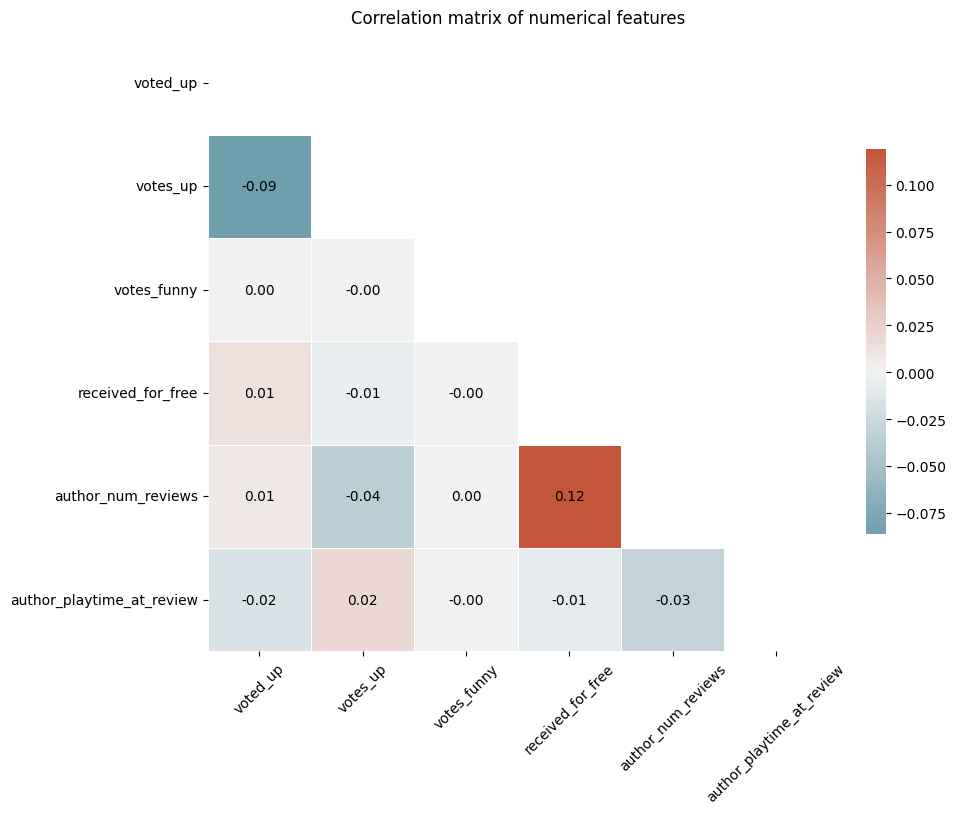

In [56]:
import numpy as np

# Plot the correlation matrix
corr = numerical_df.corr()

plt.figure(figsize=(10, 10))

# Change the color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"color": "black"})

# Update the x and y ticks to exclude the last label if it's part of the masked area
# xticks = [label if idx < len(corr.columns) - 1 else '' for idx, label in enumerate(corr.columns)]
# yticks = [label if idx < len(corr.columns) - 1 else '' for idx, label in enumerate(corr.index)]

# plt.xticks(ticks=np.arange(len(xticks)), labels=xticks, rotation=45)
# plt.yticks(ticks=np.arange(len(yticks)), labels=yticks)

plt.xticks(rotation=45)

plt.title("Correlation matrix of numerical features")
plt.show()

Positive correlation between received_for_free and author_num_reviews: 
Developers might send game copies to Steam curators, who recieve games for free and in turn write reviews for them.

<!-- Positive correlation between votes_up and average_playtime_forever:
The more time you spend on a game, the likely other players find your comments are useful. -->

### Language-based Analysis

#### Average play time (skip)

In [57]:
# # Group by language and calculate the average playtime
# grouped = combined_df.groupby('language')['Average playtime forever'].mean().reset_index()

# # Discard languages with less than 100 reviews
# grouped = grouped[grouped['Average playtime forever'] > 100]

# # Sort the languages by average playtime
# grouped = grouped.sort_values(by='Average playtime forever', ascending=False)

# # Plot the average playtime for each language
# plt.figure(figsize=(10, 10))
# sns.barplot(x='Average playtime forever', y='language', data=grouped)
# plt.title("Average playtime for each language")
# plt.show()


#### Each language's most voted-up genres

In [58]:
g_df = combined_df.copy()
g_df['Genres'] = g_df['Genres'].fillna('Unknown')  # Replace 'nan' with 'Unknown'
g_df['Genres'] = g_df['Genres'].astype(str).str.split(',')
g_df = g_df.explode('Genres')

# Convert 'voted_up' to an integer for summation
g_df['voted_up'] = g_df['voted_up'].astype(int)
g_df['total_votes'] = 1

g_df = g_df[g_df['Genres'] != 'Unknown']

# Group by 'language' and 'Genres', summing up 'voted_up_count' and 'total_votes'
grouped = g_df.groupby(['language', 'Genres']).agg({
    'voted_up': 'sum',
    'total_votes': 'sum'
}).reset_index()

# Calculate the rate of vote-up
grouped['vote_up_rate'] = grouped['voted_up'] / grouped['total_votes']

# Filter genres with more than 50 total votes
grouped = grouped[grouped['total_votes'] > 300]

# Sort and pick top 3 genres for each language
top_genres = grouped.groupby('language').apply(
    lambda x: x.nlargest(3, 'vote_up_rate')).reset_index(drop=True)

# Save the top genres for each language
top_genres.to_csv("top_genres_voted_up.csv", index=False)

# # Finding the genre with the highest vote-up rate per language
# highest_vote_up_rate = grouped.loc[grouped.groupby('language')['vote_up_rate'].idxmax()]

# print(highest_vote_up_rate)

# Printing out the results
# for language in top_genres['language'].unique():
#     print(f"Top 3 Genres for {language}:")
#     top_for_language = top_genres[top_genres['language'] == language].reset_index(drop=True)
#     for index, row in top_for_language.iterrows():
#         print(f"{index + 1}. Genre: {row['Genres']}, Vote-Up Rate: {row['vote_up_rate']:.2f}")

/var/folders/yr/j52_v7gd123d41hpdvm7_r9m0000gn/T/ipykernel_29921/1785036641.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_genres = grouped.groupby('language').apply(


#### Each language's most played genres (longest average play time at review)

In [59]:
g_df = combined_df.copy()
g_df['Genres'] = g_df['Genres'].fillna('Unknown')  # Replace 'nan' with 'Unknown'
g_df['Genres'] = g_df['Genres'].astype(str).str.split(',')
g_df = g_df.explode('Genres')

# Group by 'language' and 'Genres', calculating average playing time and sample count
grouped = g_df.groupby(['language', 'Genres']).agg(
    average_playtime=('author_playtime_at_review', 'mean'),
    sample_count=('AppID', 'size')  # AppID is just a placeholder for counting rows
).reset_index()

# Filter groups with at least 100 samples
grouped = grouped[grouped['sample_count'] >= 300]

# Sorting and selecting the top 3 genres for each language based on average playing time
top_genres = grouped.groupby('language').apply(
    lambda x: x.nlargest(3, 'average_playtime')).reset_index(drop=True)

# Save the top genres to a CSV file
top_genres.to_csv("top_genres.csv", index=False)

# # Printing out the results
# for language in top_genres['language'].unique():
#     print(f"Top 3 Genres for {language} based on Average Playing Time:")
#     top_for_language = top_genres[top_genres['language'] == language]
#     for index, row in top_for_language.iterrows():
#         print(f"{index + 1}. Genre: {row['Genres']}, Average Playing Time: {row['average_playtime']:.2f} minutes")

/var/folders/yr/j52_v7gd123d41hpdvm7_r9m0000gn/T/ipykernel_29921/973623295.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_genres = grouped.groupby('language').apply(


#### Each language's most voted-up categories

In [60]:
g_df = combined_df.copy()
g_df['Categories'] = g_df['Categories'].fillna('Unknown')  # Replace 'nan' with 'Unknown'
g_df['Categories'] = g_df['Categories'].astype(str).str.split(',')
g_df = g_df.explode('Categories')

# Convert 'voted_up' to an integer for summation
g_df['voted_up'] = g_df['voted_up'].astype(int)
g_df['total_votes'] = 1

g_df = g_df[g_df['Categories'] != 'Unknown']

# Group by 'language' and 'Genres', summing up 'voted_up_count' and 'total_votes'
grouped = g_df.groupby(['language', 'Categories']).agg({
    'voted_up': 'sum',
    'total_votes': 'sum'
}).reset_index()

# Calculate the rate of vote-up
grouped['vote_up_rate'] = grouped['voted_up'] / grouped['total_votes']

# Filter genres with more than 50 total votes
grouped = grouped[grouped['total_votes'] > 300]

# Sort and pick top 3 genres for each language
top_genres = grouped.groupby('language').apply(
    lambda x: x.nlargest(3, 'vote_up_rate')).reset_index(drop=True)

# Save the top genres for each language
top_genres.to_csv("top_categories_voted_up.csv", index=False)

# # Finding the genre with the highest vote-up rate per language
# highest_vote_up_rate = grouped.loc[grouped.groupby('language')['vote_up_rate'].idxmax()]

# print(highest_vote_up_rate)

# # Printing out the results
# for language in top_genres['language'].unique():
#     print(f"Top 3 Genres for {language}:")
#     top_for_language = top_genres[top_genres['language'] == language].reset_index(drop=True)
#     for index, row in top_for_language.iterrows():
#         print(f"{index + 1}. Categories: {row['Categories']}, Vote-Up Rate: {row['vote_up_rate']:.2f}")

/var/folders/yr/j52_v7gd123d41hpdvm7_r9m0000gn/T/ipykernel_29921/1713111536.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_genres = grouped.groupby('language').apply(


### Each language's most played categories (longest average play time at review)

In [61]:
g_df = combined_df.copy()
g_df['Categories'] = g_df['Categories'].fillna('Unknown')  # Replace 'nan' with 'Unknown'
g_df['Categories'] = g_df['Categories'].astype(str).str.split(',')
g_df = g_df.explode('Categories')

# Group by 'language' and 'Genres', calculating average playing time and sample count
grouped = g_df.groupby(['language', 'Categories']).agg(
    average_playtime=('author_playtime_at_review', 'mean'),
    sample_count=('AppID', 'size')  # AppID is just a placeholder for counting rows
).reset_index()

# Filter groups with at least 100 samples
grouped = grouped[grouped['sample_count'] >= 300]

# Sorting and selecting the top 3 genres for each language based on average playing time
top_genres = grouped.groupby('language').apply(
    lambda x: x.nlargest(3, 'average_playtime')).reset_index(drop=True)

# Save the top genres to a CSV file
top_genres.to_csv("top_categories.csv", index=False)

# # Printing out the results
# for language in top_genres['language'].unique():
#     print(f"Top 3 Genres for {language} based on Average Playing Time:")
#     top_for_language = top_genres[top_genres['language'] == language]
#     for index, row in top_for_language.iterrows():
#         print(f"{index + 1}. Genre: {row['Genres']}, Average Playing Time: {row['average_playtime']:.2f} minutes")

/var/folders/yr/j52_v7gd123d41hpdvm7_r9m0000gn/T/ipykernel_29921/1585475951.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_genres = grouped.groupby('language').apply(


### Language of review, supported languages and voted_up

In [62]:
lan_df = combined_df.copy()
lan_df.dropna(subset=['Supported languages', 'language'], inplace=True)
lan_df['Supported languages'] = lan_df['Supported languages'].str.replace("K'iche", "'K\\'iche")
lan_df['Supported languages'] = lan_df['Supported languages'].apply(ast.literal_eval)
lan_df.head()

all_lan = set([lan for sublist in lan_df['Supported languages'] for lan in sublist])
print(all_lan)

NameError: name 'ast' is not defined

### word cloud

In [ ]:
# this is slow, might take like 8 mins

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from string import punctuation

# stemming
stemmer = PorterStemmer()
# stopwords
sw = set(stopwords.words("english"))
sw.update(["game", "games", "game,"])

def makewordcloud(wordcounter:Counter, title):
    wordcloud = WordCloud(width=600, height=300).generate_from_frequencies(frequencies=dict(wordcounter))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

worddf = combined_df[["language", "review"]]

# overall word cloud (english)
worddf_eng = worddf.loc[worddf["language"] == "english"]
wordcounter = Counter()

for reviewtext in worddf_eng["review"]:
    txt = reviewtext.strip().lower()
    txt = ''.join(filter(lambda x: x.isalpha() or x.isdigit() or x.isspace(), txt))
    words = txt.split()
    words = [w for w in words if w not in sw]
    words = [stemmer.stem(w) for w in words]
    wordcounter.update(words)

makewordcloud(wordcounter, "wordcloud, english, stemmed")

### Genres vs Voted_up

In [ ]:
genres_df = combined_df.copy()
genres_df['Genres'] = genres_df['Genres'].astype(str).str.split(',')
genres_df.head()


,Unnamed: 0,AppID,Name,Genres,Average playtime forever,Estimated owners,Supported languages,language,voted_up,votes_up,votes_funny,received_for_free,author_num_reviews,review
0,0,1469160,Wartune Reborn,"[Adventure, Casual, Free to Play, Massively Mu...",0,50000 - 100000,['English'],english,0,156,3,0,141,Played this game about 10 years ago for a cou...
1,1,1026420,WARSAW,"[Indie, RPG]",67,20000 - 50000,"['English', 'French', 'German', 'Polish', 'Rus...",english,1,144,1,0,11,"ok, i just here to spread the words that you c..."
2,2,1026420,WARSAW,"[Indie, RPG]",67,20000 - 50000,"['English', 'French', 'German', 'Polish', 'Rus...",english,0,211,4,0,15,Devs removed a lot of actual content and strat...
3,3,1026420,WARSAW,"[Indie, RPG]",67,20000 - 50000,"['English', 'French', 'German', 'Polish', 'Rus...",english,0,206,9,0,154,They took away the strategy elements of the ga...
4,4,1026420,WARSAW,"[Indie, RPG]",67,20000 - 50000,"['English', 'French', 'German', 'Polish', 'Rus...",english,0,164,1,0,87,Bought this game for the strategy not the stor...


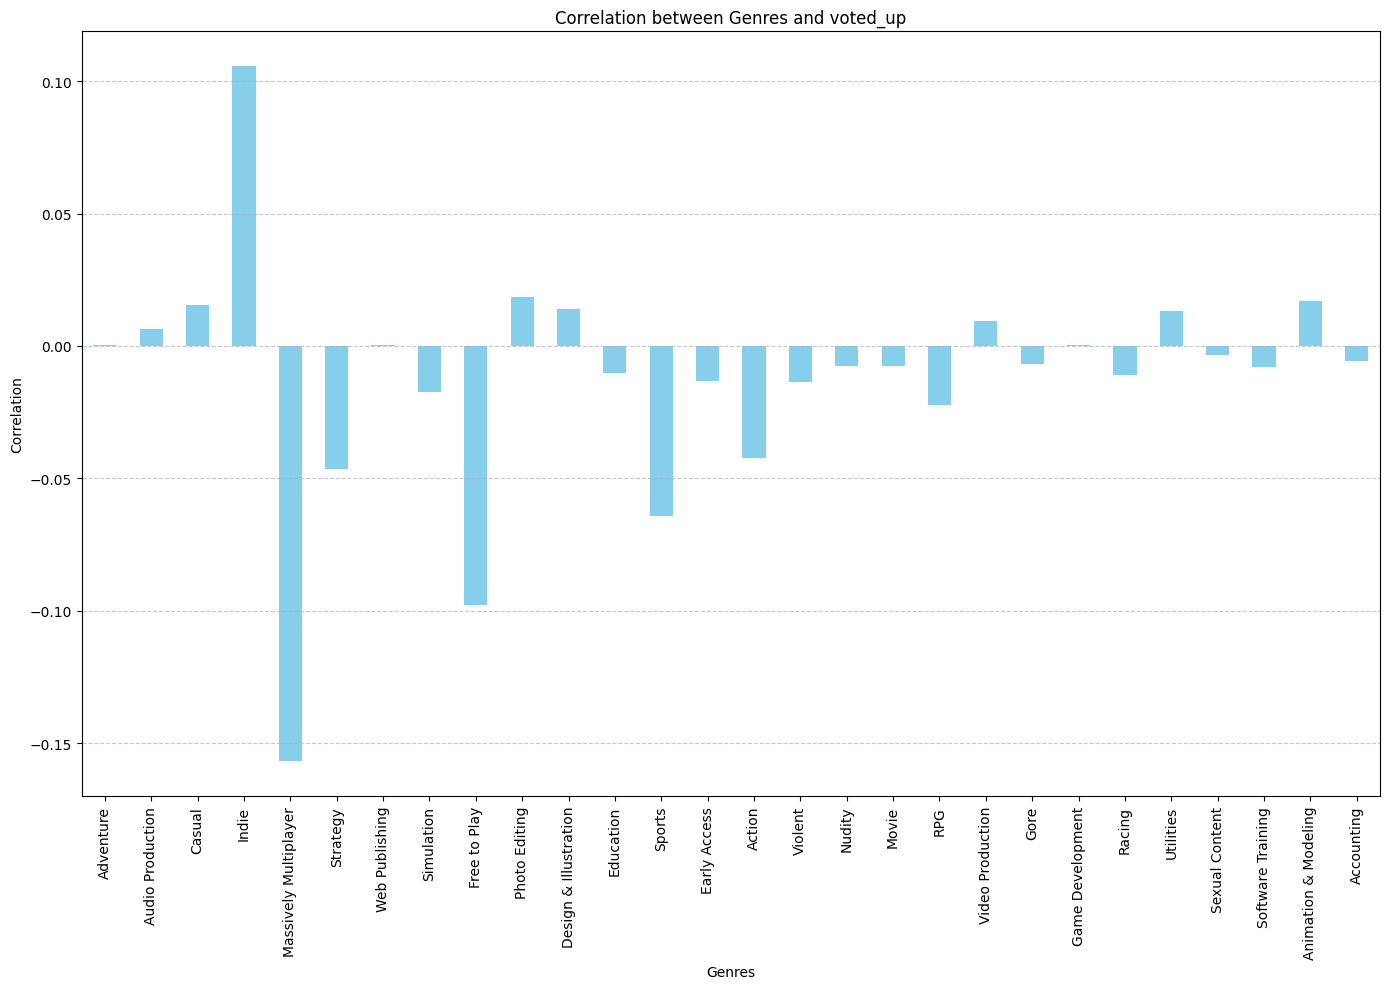

<Figure size 640x480 with 0 Axes>

In [ ]:
all_genres = set([genre for sublist in genres_df['Genres'] for genre in sublist if genre != 'nan'])
# print(all_genres)
for genre in all_genres:
    genres_df[genre] = genres_df['Genres'].apply(lambda x: 1 if genre in x else 0)

# combined_df.head()

# Calculate the correlation between genres and 'voted_up'
genre_correlation = genres_df[list(all_genres) + ['voted_up']].corr()['voted_up'].drop('voted_up')

# Plot the correlation values
plt.figure(figsize=(14, 10))
genre_correlation.plot(kind='bar', color='skyblue')
plt.title('Correlation between Genres and voted_up')
plt.xlabel('Genres')
plt.ylabel('Correlation')
# plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.savefig('genres_voted-up.png')

### Categories vs voted_up

In [ ]:
categories_df = combined_df.copy()
categories_df['Categories'] = categories_df['Categories'].astype(str).str.split(',')
# categories_df.head()

{'Shared/Split Screen', 'MMO', 'Tracked Controller Support', 'Cross-Platform Multiplayer', 'Steam Workshop', 'VR Support', 'Commentary available', 'Steam Turn Notifications', 'Steam Leaderboards', 'Remote Play on Phone', 'Partial Controller Support', 'Multi-player', 'Co-op', 'Remote Play on TV', 'Includes level editor', 'Steam Cloud', 'Steam Trading Cards', 'Full controller support', 'Stats', 'PvP', 'Mods', 'Remote Play Together', 'Shared/Split Screen PvP', 'Includes Source SDK', 'Shared/Split Screen Co-op', 'In-App Purchases', 'Valve Anti-Cheat enabled', 'Mods (require HL2)', 'Captions available', 'Single-player', 'Remote Play on Tablet', 'Online PvP', 'VR Only', 'SteamVR Collectibles', 'LAN Co-op', 'LAN PvP', 'Steam Achievements', 'Online Co-op'}


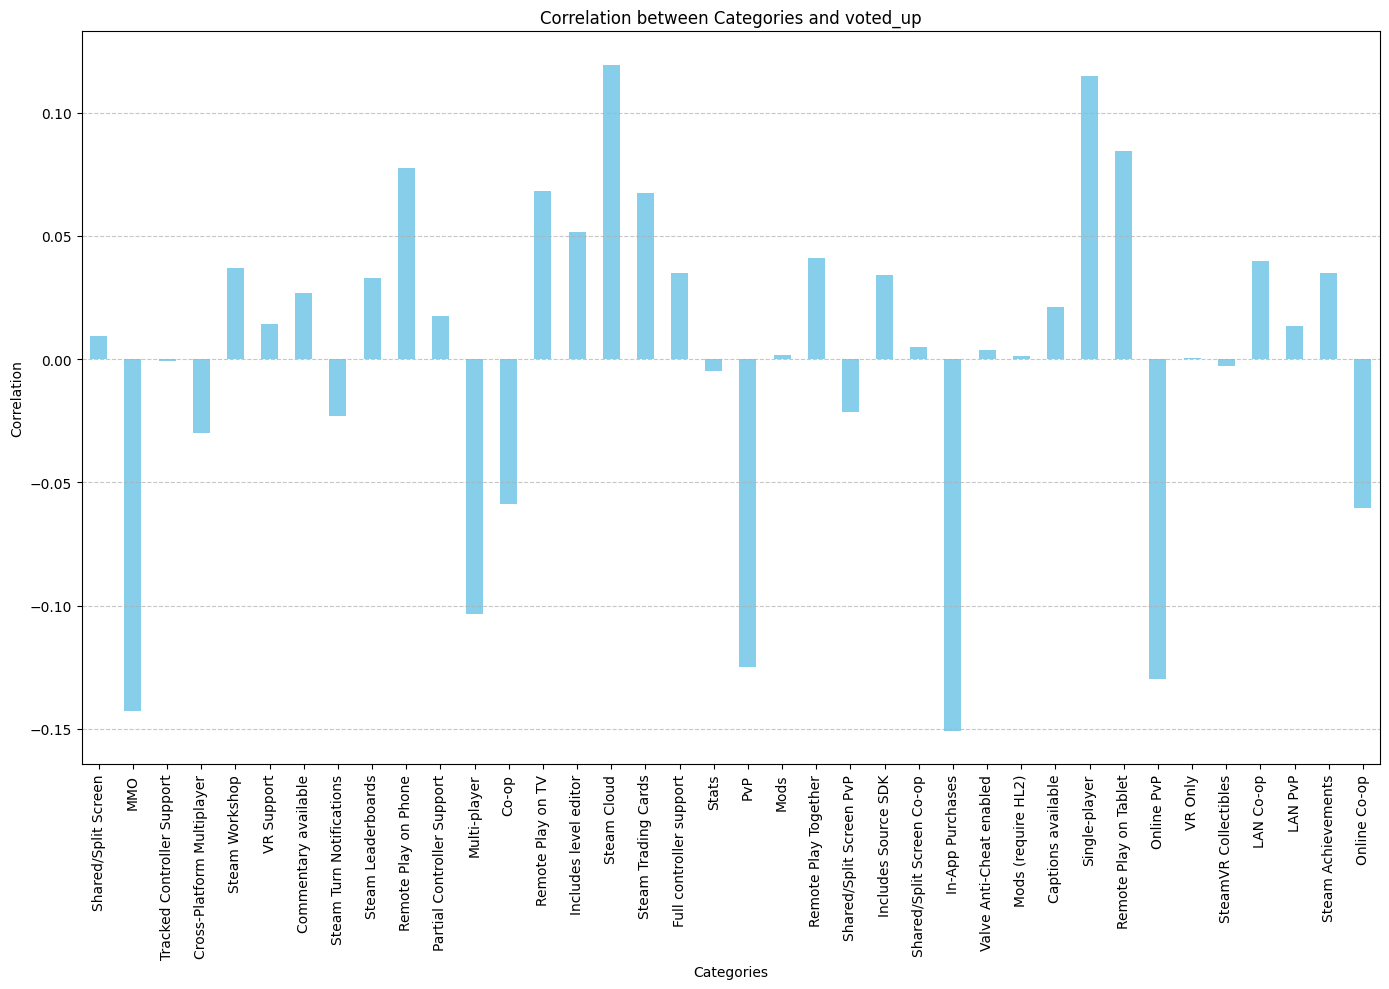

In [ ]:
all_categories = set([category for sublist in categories_df['Categories'] for category in sublist if category != 'nan'])
print(all_categories)
for category in all_categories:
    categories_df[category] = categories_df['Categories'].apply(lambda x: 1 if category in x else 0)

# combined_df.head()

# Calculate the correlation between genres and 'voted_up'
genre_correlation = categories_df[list(all_categories) + ['voted_up']].corr()['voted_up'].drop('voted_up')

# Plot the correlation values
plt.figure(figsize=(14, 10))
genre_correlation.plot(kind='bar', color='skyblue')
plt.title('Correlation between Categories and voted_up')
plt.xlabel('Categories')
plt.ylabel('Correlation')
# plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()